# Monte Carlo Simulations

**This script performs a Monte Carlo simulation to evaluate the expected return and risk (volatility) of a portfolio made up of selected stocks.**

Overall, this simulation helps you choose an allocation strategy:

- Go for Max Sharpe if you're comfortable with some volatility and want high growth.
- Choose Min Vol if you're risk-averse.
- Or pick something between the two for a balanced portfolio.

In [5]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

## Data Loading and Preparation

In [2]:
# Path to your zip file
zip_path = 'Stock Portfolio Optimization Dataset.zip'

In [3]:
# Create a dictionary to store all DataFrames
dataframes = {}

# List of expected files
expected_files = [
    'all_ten.csv',
    'original_risks_returns.csv',
    'stock_data2.csv',
    'stock_data3.csv',
    'stock_data_strong.csv',
    'stock_data_weak.csv',
    'strong_risks_returns.csv',
    'weak_risks_returns.csv'
]

# Load all files from the zip archive
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Check which expected files are present
    available_files = [f for f in expected_files if f in zip_ref.namelist()]
    
    # Load each available file into a DataFrame
    for file in available_files:
        with zip_ref.open(file) as f:
            # Remove .csv extension for cleaner dictionary keys
            df_name = file.replace('.csv', '')
            dataframes[df_name] = pd.read_csv(f)
            
    # Print loaded files
    print("Successfully loaded the following files:")
    for file in available_files:
        print(f"- {file}")
    
    # Print any missing expected files
    missing_files = set(expected_files) - set(available_files)
    if missing_files:
        print("\nThe following expected files were not found in the zip:")
        for file in missing_files:
            print(f"- {file}")

Successfully loaded the following files:
- all_ten.csv
- original_risks_returns.csv
- stock_data2.csv
- stock_data3.csv
- stock_data_strong.csv
- stock_data_weak.csv
- strong_risks_returns.csv
- weak_risks_returns.csv


## Define Function for Simulation (enhanced_monte_carlo_simulation)

This function simulates thousands of portfolios using historical returns to analyze expected performance.

In [6]:
def enhanced_monte_carlo_simulation(returns_df, num_simulations=25000, risk_free_rate=0.02):
    """
    Enhanced Monte Carlo simulation with additional analytics and visualization
    
    Parameters:
    returns_df: DataFrame of asset returns (columns=assets)
    num_simulations: Number of random portfolios to generate (default: 25,000)
    risk_free_rate: Annual risk-free rate (default: 2%)
    
    Returns:
    Tuple of (results_df, optimal_portfolios, frontier_df)
    """
    # Calculate statistics
    mean_returns = returns_df.mean() * 252  # Annualize
    cov_matrix = returns_df.cov() * 252     # Annualize
    num_assets = len(returns_df.columns)
    
    # Initialize results storage
    results = np.zeros((num_simulations, num_assets + 3))  # Weights + Return + Vol + Sharpe
    frontier = []
    
    # Run simulations
    for i in range(num_simulations):
        # Generate random weights that sum to 1
        weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
        
        # Calculate portfolio metrics
        port_return = np.sum(mean_returns * weights)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (port_return - risk_free_rate) / port_vol
        
        # Store results
        results[i,:num_assets] = weights
        results[i,num_assets] = port_return
        results[i,num_assets+1] = port_vol
        results[i,num_assets+2] = sharpe
    
    # Create DataFrames
    cols = list(returns_df.columns) + ['Return', 'Volatility', 'Sharpe']
    results_df = pd.DataFrame(results, columns=cols)
    
    # Identify optimal portfolios
    max_sharpe_idx = results_df['Sharpe'].idxmax()
    min_vol_idx = results_df['Volatility'].idxmin()
    
    optimal_portfolios = {
        'max_sharpe': results_df.loc[max_sharpe_idx].to_dict(),
        'min_vol': results_df.loc[min_vol_idx].to_dict()
    }
    
    # Generate efficient frontier
    return_range = np.linspace(
        results_df['Return'].min()*0.9,
        results_df['Return'].max()*1.1,
        100
    )
    
    frontier_vol = []
    for target_return in return_range:
        mask = (results_df['Return'] >= target_return*0.99) & \
               (results_df['Return'] <= target_return*1.01)
        if mask.any():
            frontier_vol.append(results_df[mask]['Volatility'].min())
        else:
            frontier_vol.append(np.nan)
    
    frontier_df = pd.DataFrame({
        'Return': return_range,
        'Volatility': frontier_vol
    }).dropna()
    
    return results_df, optimal_portfolios, frontier_df

This function visualizes the results of the Monte Carlo simulations — specifically, the risk-return profile of thousands of simulated portfolios.

In [7]:
def visualize_results(results_df, optimal_portfolios, frontier_df, risk_free_rate=0.02):
    """Enhanced visualization of simulation results"""
    plt.figure(figsize=(16, 8))
    
    # Create main plot
    ax1 = plt.subplot(121)
    
    # Plot all simulations
    sc = ax1.scatter(
        results_df['Volatility'], 
        results_df['Return'], 
        c=results_df['Sharpe'],
        cmap='viridis', 
        alpha=0.25, 
        s=10,
        label='Simulated Portfolios'
    )
    
    # Plot efficient frontier
    ax1.plot(
        frontier_df['Volatility'],
        frontier_df['Return'],
        'r--',
        linewidth=2,
        label='Efficient Frontier'
    )
    
    # Plot optimal portfolios
    ax1.scatter(
        optimal_portfolios['max_sharpe']['Volatility'],
        optimal_portfolios['max_sharpe']['Return'],
        marker='*',
        color='gold',
        s=500,
        edgecolor='black',
        label=f"Max Sharpe ({optimal_portfolios['max_sharpe']['Sharpe']:.2f})"
    )
    
    ax1.scatter(
        optimal_portfolios['min_vol']['Volatility'],
        optimal_portfolios['min_vol']['Return'],
        marker='*',
        color='green',
        s=500,
        edgecolor='black',
        label=f"Min Volatility"
    )
    
    # Plot risk-free rate
    ax1.plot(
        0, 
        risk_free_rate, 
        'bo',
        markersize=10,
        label='Risk-Free Rate'
    )
    
    # Formatting
    ax1.set_title('Portfolio Optimization Space', fontsize=14)
    ax1.set_xlabel('Annualized Volatility', fontsize=12)
    ax1.set_ylabel('Annualized Return', fontsize=12)
    ax1.xaxis.set_major_formatter(PercentFormatter(1))
    ax1.yaxis.set_major_formatter(PercentFormatter(1))
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # Add colorbar
    plt.colorbar(sc, ax=ax1, label='Sharpe Ratio')
    
    # Create allocation plot
    ax2 = plt.subplot(122)
    
    # Prepare weights data
    weights_data = {k:v for k,v in optimal_portfolios['max_sharpe'].items() 
                   if k in results_df.columns[:-3]}
    weights_series = pd.Series(weights_data).sort_values(ascending=False)
    
    # Plot weights
    weights_series.plot(
        kind='bar',
        ax=ax2,
        color=plt.cm.tab20.colors,
        edgecolor='black',
        width=0.8
    )
    
    # Formatting
    ax2.set_title('Optimal Portfolio Allocation', fontsize=14)
    ax2.set_ylabel('Weight Allocation', fontsize=12)
    ax2.yaxis.set_major_formatter(PercentFormatter(1))
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, axis='y', alpha=0.3)
    
    # Add weight percentages
    for i, v in enumerate(weights_series):
        ax2.text(i, v + 0.01, f"{v:.1%}", ha='center')
    
    plt.tight_layout()
    plt.show()

This is a wrapper function to streamline the entire process — it runs the Monte Carlo simulation and then visualizes the results.


======================== PORTFOLIO OPTIMIZATION RESULTS ========================

Simulation Statistics:             
----------------------------------------
Number of simulations:   25,000
Average return:          11.52%
Average volatility:      13.50%
Best Sharpe ratio:       1.77


------------------------------ Optimal Portfolios ------------------------------

Maximum Sharpe Ratio Portfolio:
Return:        25.35%
Volatility:    13.19%
Sharpe Ratio:  1.77

Minimum Volatility Portfolio:
Return:        12.81%
Volatility:    10.25%
Sharpe Ratio:  1.05


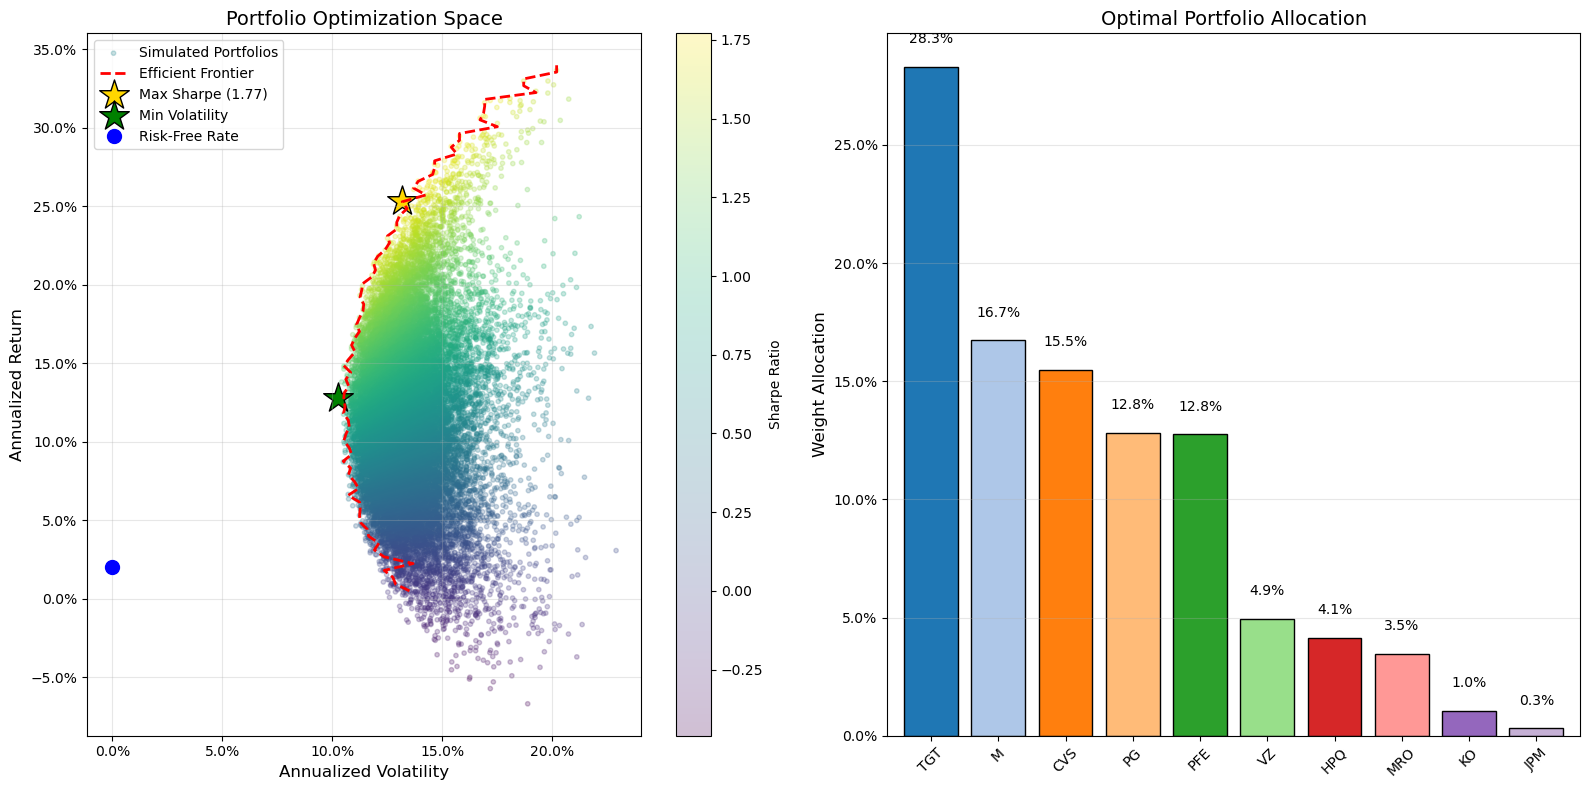

In [8]:
def comprehensive_analysis(returns_df, num_simulations=25000, risk_free_rate=0.02):
    """Complete analysis workflow"""
    # Run simulation
    results_df, optimal_portfolios, frontier_df = enhanced_monte_carlo_simulation(
        returns_df, 
        num_simulations, 
        risk_free_rate
    )
    
    # Print summary statistics
    print("\n" + "="*80)
    print(" PORTFOLIO OPTIMIZATION RESULTS ".center(80, "="))
    print("="*80)
    
    print(f"\n{'Simulation Statistics:':<25}{'':<10}")
    print(f"{'-'*40}")
    print(f"{'Number of simulations:':<25}{num_simulations:,}")
    print(f"{'Average return:':<25}{results_df['Return'].mean():.2%}")
    print(f"{'Average volatility:':<25}{results_df['Volatility'].mean():.2%}")
    print(f"{'Best Sharpe ratio:':<25}{results_df['Sharpe'].max():.2f}")
    
    # Print optimal portfolios
    print("\n\n" + " Optimal Portfolios ".center(80, "-"))
    
    print("\nMaximum Sharpe Ratio Portfolio:")
    print(f"{'Return:':<15}{optimal_portfolios['max_sharpe']['Return']:.2%}")
    print(f"{'Volatility:':<15}{optimal_portfolios['max_sharpe']['Volatility']:.2%}")
    print(f"{'Sharpe Ratio:':<15}{optimal_portfolios['max_sharpe']['Sharpe']:.2f}")
    
    print("\nMinimum Volatility Portfolio:")
    print(f"{'Return:':<15}{optimal_portfolios['min_vol']['Return']:.2%}")
    print(f"{'Volatility:':<15}{optimal_portfolios['min_vol']['Volatility']:.2%}")
    print(f"{'Sharpe Ratio:':<15}{optimal_portfolios['min_vol']['Sharpe']:.2f}")
    
    # Visualize results
    visualize_results(results_df, optimal_portfolios, frontier_df, risk_free_rate)
    
    return results_df, optimal_portfolios, frontier_df

# Example usage:
if __name__ == "__main__":
    # Load your returns data (example with random data)
    np.random.seed(42)
    assets = ['PFE', 'TGT', 'M', 'VZ', 'JPM', 'MRO', 'KO', 'PG', 'CVS', 'HPQ']
    data = {asset: np.random.normal(0.0005, 0.02, 1000) for asset in assets}
    returns_df = pd.DataFrame(data)
    
    # Run complete analysis
    results, optimal, frontier = comprehensive_analysis(returns_df)

### Simulation Statistics

- Number of simulations	(25,000) You tested 25,000 different random portfolio allocations. The more, the better the estimate.
- Average return (11.52%) The average annual return across all simulated portfolios.
- Average volatility (13.50%) The average standard deviation (risk) across all portfolios.
- Best Sharpe ratio (1.77) The highest risk-adjusted return found among all 25,000 simulations. The Sharpe Ratio measures return per unit of risk. A Sharpe above 1.0 is solid; 1.77 is excellent.

### Optimal Portfolios

1. Maximum Sharpe Ratio Portfolio

This is your most efficient portfolio — the one that gives you the best return for the amount of risk you're taking.

- Return: 25.35%
- Volatility: 13.19%
- Sharpe Ratio: 1.77
- Use case: Ideal for aggressive investors who want maximum return per unit of risk.

2. Minimum Volatility Portfolio

This is the safest portfolio — lowest risk regardless of return.

- Return: 12.81%
- Volatility: 10.25%
- Sharpe Ratio: 1.05
- Use case: Suitable for conservative investors who prioritize stability over high returns.

### Summary & Interpretation

- The average portfolio is decent: ~11.5% return and 13.5% risk — Sharpe ~0.85.
- The Max Sharpe portfolio nearly doubles the return without adding much risk — very efficient.
- The Min Volatility portfolio gives a safer option with above-average return at lower risk — also very attractive.